# Generated Dissimilarity datasets

In [78]:
import os
os.environ['MEMORY_LIMIT'] = '16GB'
import seaborn as sns
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
from os.path import exists, join
from io import StringIO  
from datetime import timedelta
import math

ALGORITHMS = {
    'structural': 'Structural',
    'structural-variant': 'Splitted Structural',
    'sed': 'Sed',
    'lblint': 'Lbl-Int',
    'bib': 'Binary branch',
    'sedindex': 'Sed Index',
    'lblindex': 'Lbl-Int Index',
    'structuralindex': 'Structural Index',
}

datasets = ('dblp', 'ptb', 'python', 'sentiment', 'swissprot', 'treefam')
ALGORITHMS_ENUM_NAMES = {
    'structural': 'Structural',
    'structural-variant': 'StructuralVariant',
    'sed': 'Sed',
    'lblint': 'Lblint',
    'bib': 'Bib'
}

In [79]:
bases = [f'base-{b}' for b in [25,100,200]]
datasets = [f'{base}/{x}' for x in ['lsmall', 'lbig'] for base in bases]

In [80]:
from os.path import join
def get_query_runtime_for_ds(basepath: str, ds: str):
    qt = join(basepath, ds, 'query_times.txt')
    # qt = f'resources/workloads/generated/{ds}/query_times.txt'
    with open(qt) as f:
        content = f.read()
    times = [l.split(':')[1].strip('ms') for i, l in enumerate(content.split('\n')) if i % 3 == 1]
    candidates = [l.split(':')[1] for i, l in enumerate(content.split('\n')) if i % 3 == 2]
    methods = [l for i, l in enumerate(content.split('\n')) if i % 3 == 0 and l]
    csv_content = ','.join(methods) + '\n' +','.join(times)  + '\n' + ','.join(candidates) + '\n'
    strio = StringIO(csv_content)
    df = pd.read_csv(strio)
    df.insert(0, 'Dataset', [ds] * 2)
    # df = df.set_index('Dataset')
    return df

In [81]:
def get_searching_part(basepath: str):
    df = pd.DataFrame()
    cdf = pd.DataFrame()
    stats_df = pd.DataFrame()
    for ds in datasets:
        tdf = get_query_runtime_for_ds(basepath, ds)
        df = pd.concat([df, tdf.iloc[[0]]])
        cdf = pd.concat([cdf, tdf.iloc[[1]]])
        stats = pd.read_csv(join(basepath, ds, 'collection.csv'))
        stats.insert(0, 'Dataset', [ds.capitalize()])
        stats_df = pd.concat([stats_df, stats])

    df = df.rename(columns={
        'Lblint index': ALGORITHMS['lblindex'],
        'Lblint': ALGORITHMS['lblint'],
        'Sed Index': ALGORITHMS['sedindex'],
        'Sed': ALGORITHMS['sed'],
        'Structural Index': ALGORITHMS['structuralindex'],
        'Structural': ALGORITHMS['structural'],
        })
    df = df.set_index('Dataset')
    cdf = cdf.set_index('Dataset')
    df['process_part'] = 'searching'

    return df, cdf, stats_df

In [82]:
# returns precision, verification times and selectivies
def get_precision_and_verification_for_ds(basepath: str, cdf: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    # precision dataframe
    pdf = pd.DataFrame()
    # verification times dataframe
    vdf = pd.DataFrame()
    selectivites = dict()
    for ds in datasets:
        temp_df = pd.DataFrame.from_dict({ 'dataset': [ds] })
        tv_df = pd.DataFrame.from_dict({ 'Dataset': [ds] })
        times_ = []
        methods = ['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural']
        for mtd in ('Lblint', 'Sed', 'Structural'):
            verification_path = join(basepath, ds, f'{mtd.lower()}-verified.txt')
            candidate_count = cdf[mtd][ds]
            
            with open(verification_path) as f:
                lines = f.read().split('\n')
            times = pd.Series([float(t) for t in lines if ',' not in t and t])
            correct_results = [l for l in lines if ',' in l and l]
            # candidate_count = 
            precision =  len(correct_results) / candidate_count
            # print(mtd, ds, candidate_count, len(correct_results))
            temp_df[mtd] = precision
            temp_df
    
            total_verification_time_ms = times.div(1_000_000).sum()
            # twice for index version
            times_.extend([total_verification_time_ms, total_verification_time_ms])
            # print(ds, mtd, precision)
        
        sdf = pd.read_csv(StringIO('\n'.join(correct_results)), names=['T1', 'T2'])
        sdf = sdf[sdf['T1'] != sdf['T2']].sort_values(by='T1')
        m = sdf.groupby('T1').count().mean(axis=0)
        selectivity = 100 * ((m.reset_index()[0][0]) / 1000)
        selectivites[ds] = {'Selectivity':  selectivity }
        pdf = pd.concat([pdf, temp_df])
        vdf = pd.concat([vdf, pd.DataFrame.from_dict({'Dataset': [ds] * 6, 'process_part': ['verification'] * 6, 'Method': methods, 'Time': times_, }) ])
        
    
    sdf = pd.DataFrame.from_dict(selectivites)
    pdf = pdf.set_index("dataset")
    vdf.sort_values(['Method', 'Dataset'], inplace=True)
    return pdf, vdf, sdf


In [83]:
def plot_selectivity(sdf):
    # plt.figure(figsize=(18, 12))
    bx = sns.barplot(sdf, width=0.6)
    # bx.tick_params(axis='x', rotation=45, rotation_mode='anchor'labelsize=10, ha='left')
    bx.set_xticklabels(bx.get_xticklabels(), 
                       rotation=45,     # Rotation angle
                       ha='right',      # Horizontal alignment: 'left', 'center', or 'right'
                       rotation_mode='anchor')  # Ensures alignment works with rotation
    
    # Add value annotations on top of each bar
    for i, ds in enumerate(datasets):
        v = sdf[ds]['Selectivity']
        bx.text(i, round(v, 2), str(round(v, 2)) + '%', 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')
    return bx


In [84]:
def plot_precision(pdf, ax=None):
    return sns.heatmap(pdf, annot=True, ax=ax)

In [85]:
from dataclasses import dataclass

In [86]:
@dataclass
class PlotData:
    pdf: pd.DataFrame
    vdf: pd.DataFrame
    sdf: pd.DataFrame
    plotdata: pd.DataFrame
    statistics: pd.DataFrame

In [87]:
def get_plot_data_ds(basepath: str) -> PlotData:
    df, cdf, statistics = get_searching_part(basepath)
    pdf, vdf, sdf = get_precision_and_verification_for_ds(basepath, cdf)
    
    
    df['Dataset'] = df.index
    ldf = df.melt(id_vars=["Dataset", "process_part"], var_name="Method", value_name="Time", value_vars=['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural'])
    complete = pd.concat([ldf, vdf])
    plot_data = complete.pivot_table(
        index=['Dataset', 'Method'],
        columns='process_part',
        values='Time'
    ).reset_index()
    plot_data['total'] = plot_data['searching'] + plot_data['verification']

    return PlotData(
        pdf = pdf,
        vdf = vdf,
        sdf = sdf,
        plotdata = plot_data,
        statistics = statistics,
    )

In [17]:
hue_color_palette = {'searching': sns.color_palette()[0], 'verification': sns.color_palette()[1]}

# 10 - 20 distinct labels per tree

In [18]:
data: PlotData = get_plot_data_ds('resources/workloads/generated-1-5')

In [19]:
display(data.statistics)

,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,90,124,106.673,1000,0.041,21.455,2994,NaN
0,Base-100/lsmall,89,121,105.097,1000,0.058,19.804,2996,NaN
0,Base-200/lsmall,89,123,104.706,1000,0.087,17.658,2987,NaN
0,Base-25/lbig,91,122,106.260,1000,12.891,21.482,15494,NaN
0,Base-100/lbig,88,121,104.980,1000,12.105,19.935,14527,NaN
0,Base-200/lbig,91,122,104.758,1000,11.056,17.900,13336,NaN


<Axes: ylabel='dataset'>

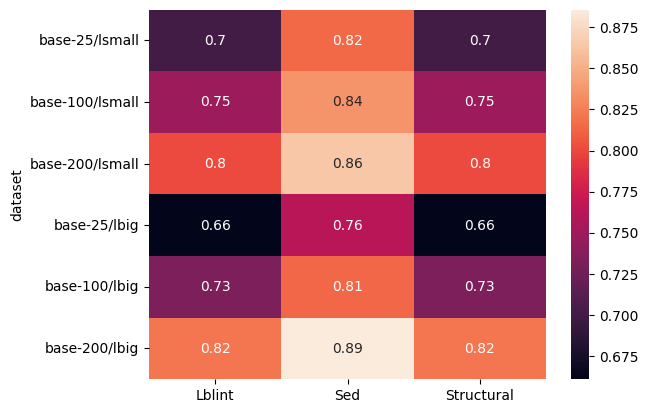

In [20]:
plot_precision(data.pdf)

In [15]:
alldf = pd.melt(data.plotdata, id_vars=['Dataset', 'Method'], value_vars=['searching', 'verification'], value_name="time")
alldf[['BaseSize', 'LabelSize']] = alldf['Dataset'].str.split('/', expand=True)
alldf[['Base', 'BaseSize']] = alldf['BaseSize'].str.split('-', expand=True)
alldf.drop('Base', axis=1, inplace=True)
alldf['BaseSize'] = alldf['BaseSize'].astype(int)

/tmp/ipykernel_13726/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


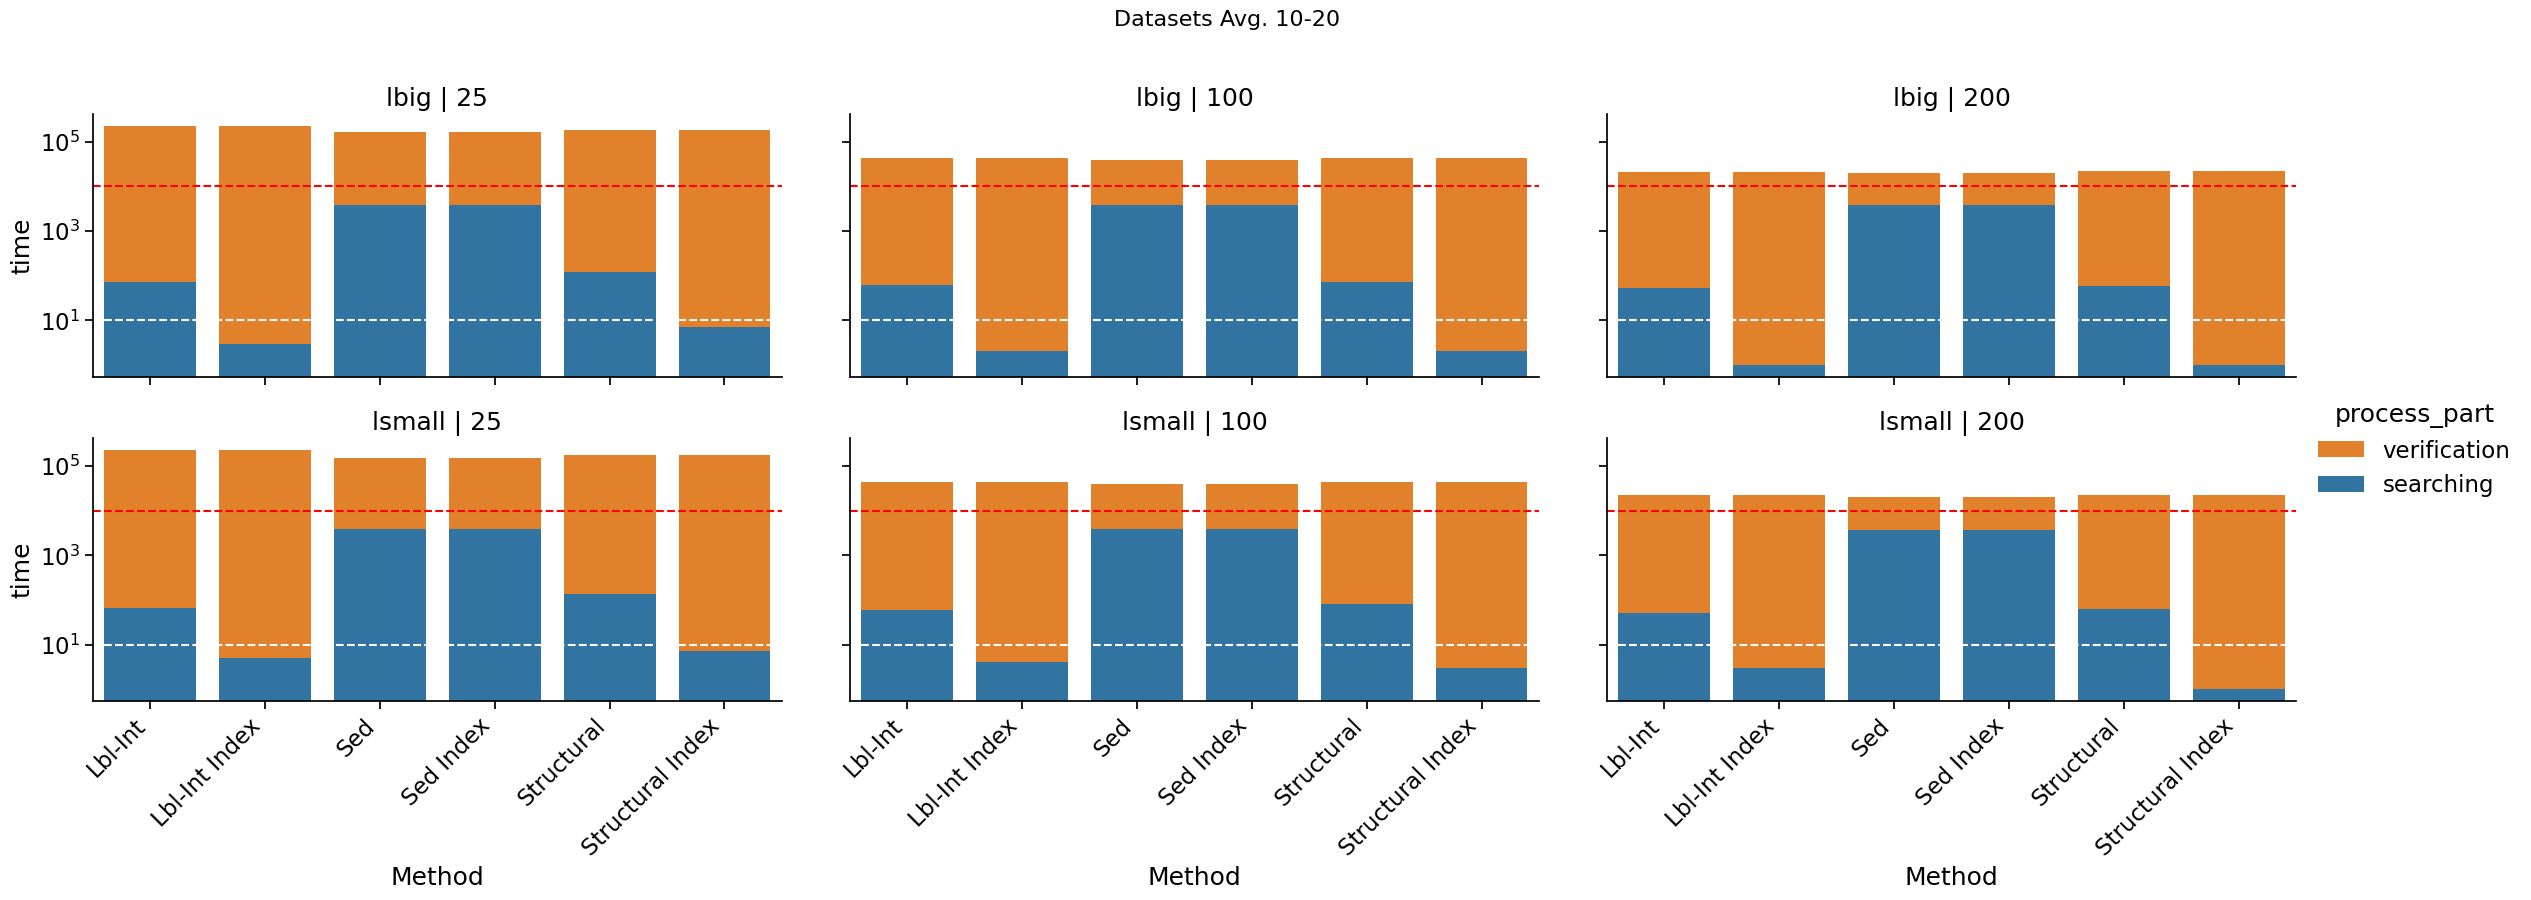

In [16]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Set the super title
g.fig.suptitle("Datasets Avg. 10-20", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
sns.set_context("notebook", font_scale=1)

# Distinct labels 30-50 per tree

In [97]:
data: PlotData = get_plot_data_ds('resources/workloads/generated-150-200')

FileNotFoundError: [Errno 2] No such file or directory: 'resources/workloads/generated-150-200/dblp/query_times.txt'

In [98]:
display(data.statistics)

AttributeError: 'DataFrame' object has no attribute 'statistics'

<Axes: ylabel='dataset'>

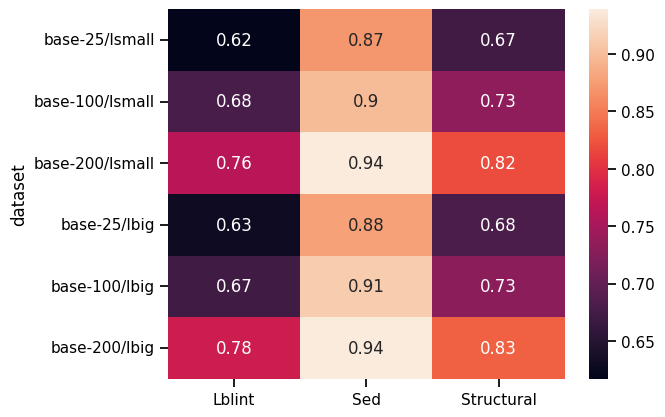

In [19]:
plot_precision(data.pdf)

In [20]:
alldf = pd.melt(data.plotdata, id_vars=['Dataset', 'Method'], value_vars=['searching', 'verification'], value_name="time")
alldf[['BaseSize', 'LabelSize']] = alldf['Dataset'].str.split('/', expand=True)
alldf[['Base', 'BaseSize']] = alldf['BaseSize'].str.split('-', expand=True)
alldf.drop('Base', axis=1, inplace=True)
alldf['BaseSize'] = alldf['BaseSize'].astype(int)

/tmp/ipykernel_13726/1778216415.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/1778216415.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/1778216415.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/1778216415.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degr

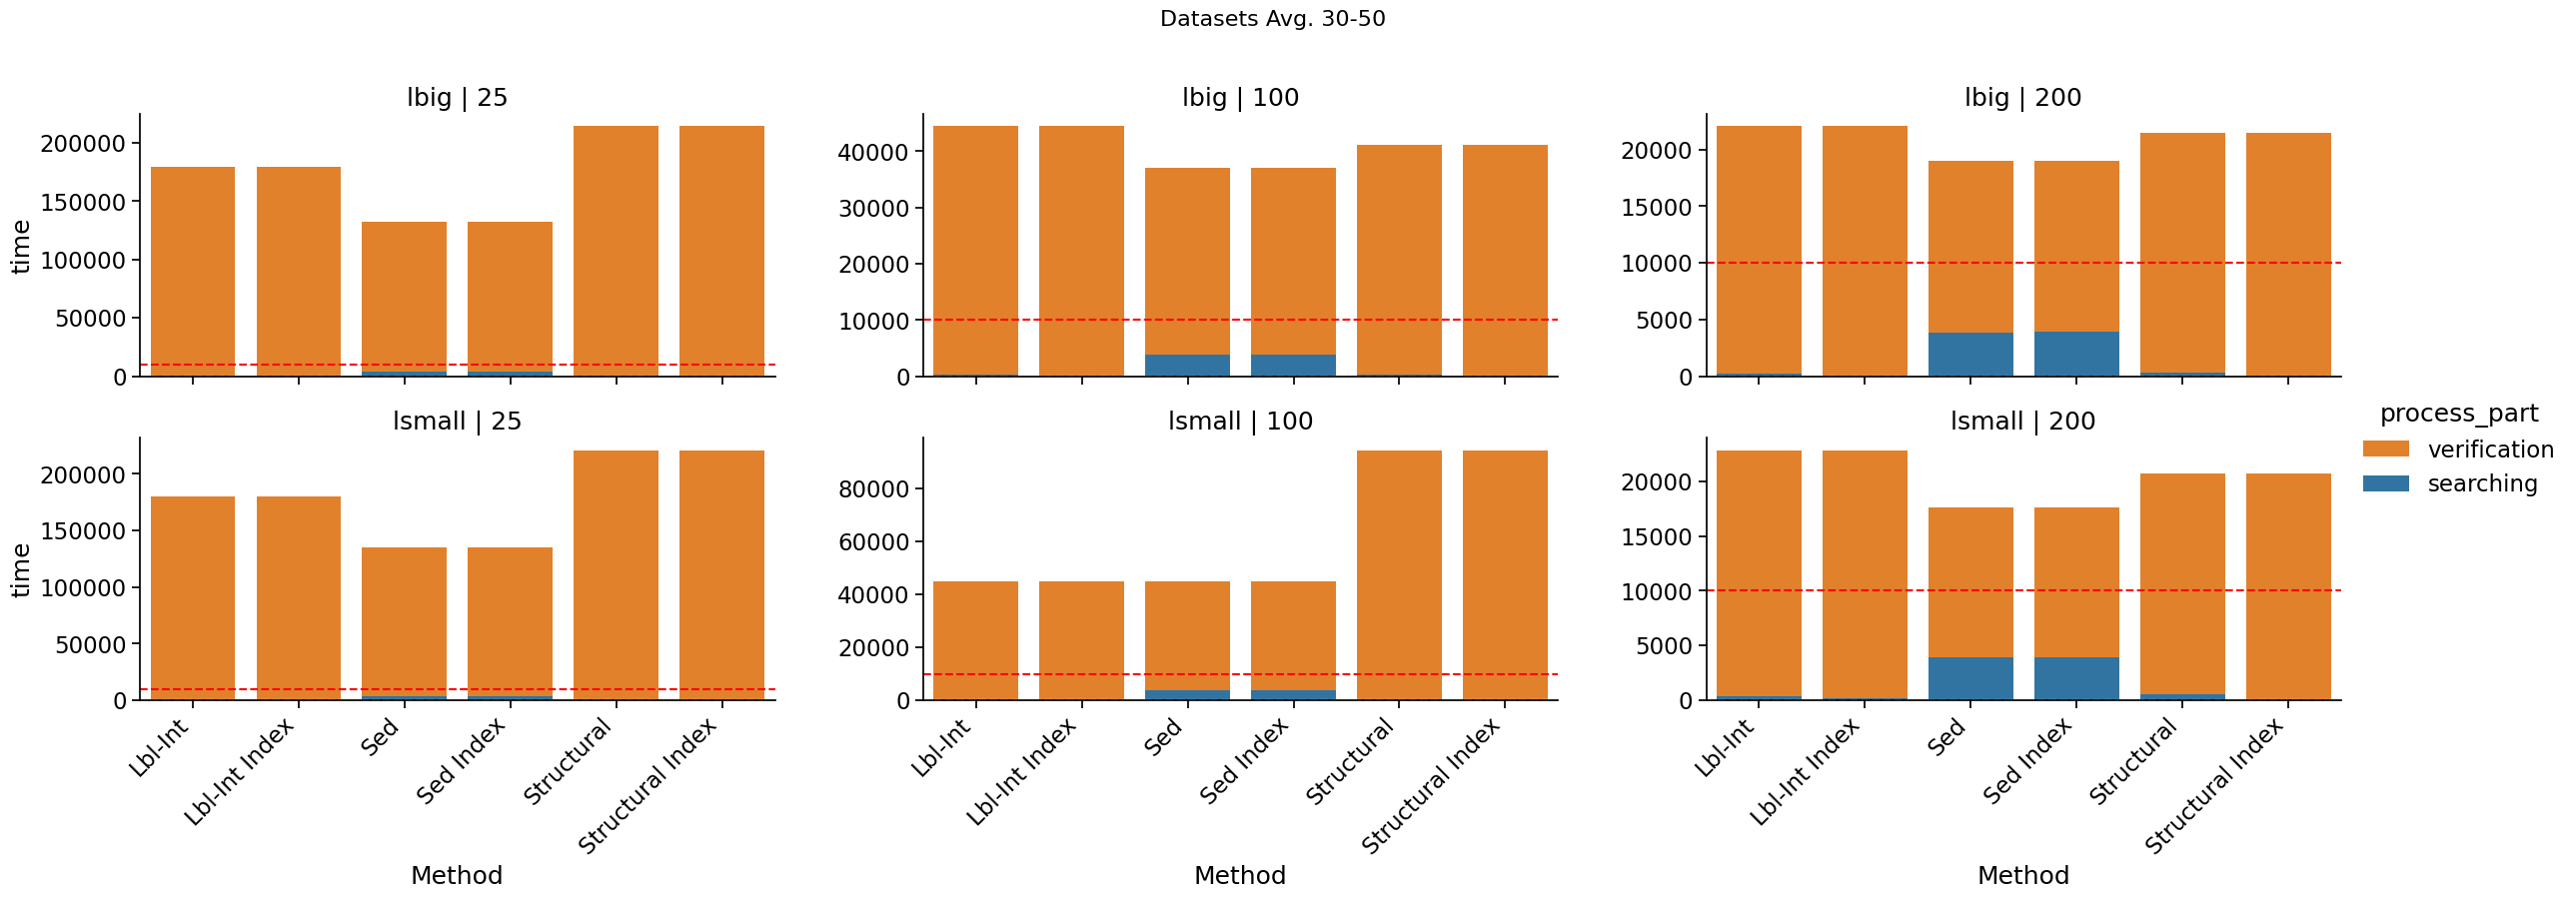

In [28]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    sharey=False,
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

# g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')
    # ax.set_yscale('log', base=math.e)

# Set the super title
g.fig.suptitle("Datasets Avg. 30-50", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
sns.set_context("notebook", font_scale=1)

# Avg. distinct labels 70 - 90 per tree

In [88]:
data: PlotData = get_plot_data_ds('resources/workloads/generated-70-90')

In [89]:
display(data.statistics)

,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,92,118,104.972,1000,0.105,66.982,2973,NaN
0,Base-100/lsmall,90,118,104.230,1000,0.036,66.275,2992,NaN
0,Base-200/lsmall,91,122,102.858,1000,0.006,64.708,2999,NaN
0,Base-25/lbig,88,119,104.114,1000,9.927,66.867,12541,NaN
0,Base-100/lbig,88,117,102.998,1000,8.589,66.091,14910,NaN
0,Base-200/lbig,91,117,102.890,1000,6.977,65.326,17836,NaN


<Axes: ylabel='dataset'>

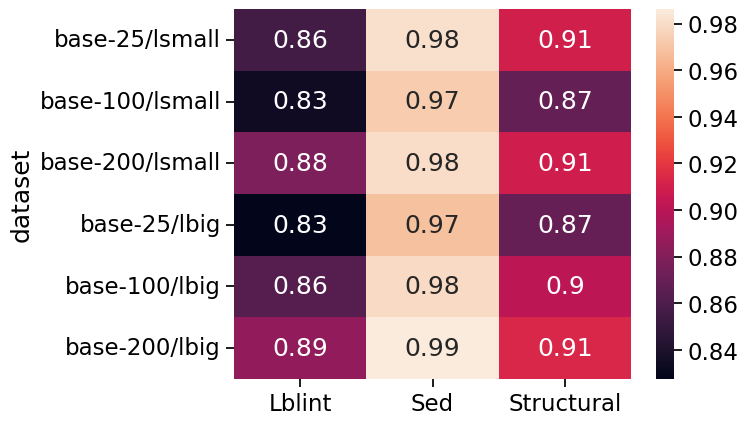

In [90]:
plot_precision(data.pdf)

In [65]:
alldf = pd.melt(data.plotdata, id_vars=['Dataset', 'Method'], value_vars=['searching', 'verification'], value_name="time")
alldf[['BaseSize', 'LabelSize']] = alldf['Dataset'].str.split('/', expand=True)
alldf[['Base', 'BaseSize']] = alldf['BaseSize'].str.split('-', expand=True)
alldf.drop('Base', axis=1, inplace=True)
alldf['BaseSize'] = alldf['BaseSize'].astype(int)

In [97]:
data.plotdata[['BaseSize', 'LabelSize']] = data.plotdata['Dataset'].str.split('/', expand=True)
data.plotdata[['Base', 'BaseSize']] = data.plotdata['BaseSize'].str.split('-', expand=True)
data.plotdata.drop('Base', axis=1, inplace=True)
data.plotdata['BaseSize'] = data.plotdata['BaseSize'].astype(int)
data.plotdata

process_part,Dataset,Method,searching,verification,total,BaseSize,LabelSize
0,base-100/lbig,Lbl-Int,187.0,39926.059287,40113.059287,100,lbig
1,base-100/lbig,Lbl-Int Index,10.0,39926.059287,39936.059287,100,lbig
2,base-100/lbig,Sed,3569.0,35557.990246,39126.990246,100,lbig
3,base-100/lbig,Sed Index,3619.0,35557.990246,39176.990246,100,lbig
4,base-100/lbig,Structural,205.0,38432.435468,38637.435468,100,lbig
5,base-100/lbig,Structural Index,4.0,38432.435468,38436.435468,100,lbig
6,base-100/lsmall,Lbl-Int,213.0,42470.018111,42683.018111,100,lsmall
7,base-100/lsmall,Lbl-Int Index,60.0,42470.018111,42530.018111,100,lsmall
8,base-100/lsmall,Sed,3723.0,37642.994447,41365.994447,100,lsmall
9,base-100/lsmall,Sed Index,3715.0,37642.994447,41357.994447,100,lsmall


In [102]:
hue_color_palette

{'searching': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'verification': (1.0, 0.4980392156862745, 0.054901960784313725)}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

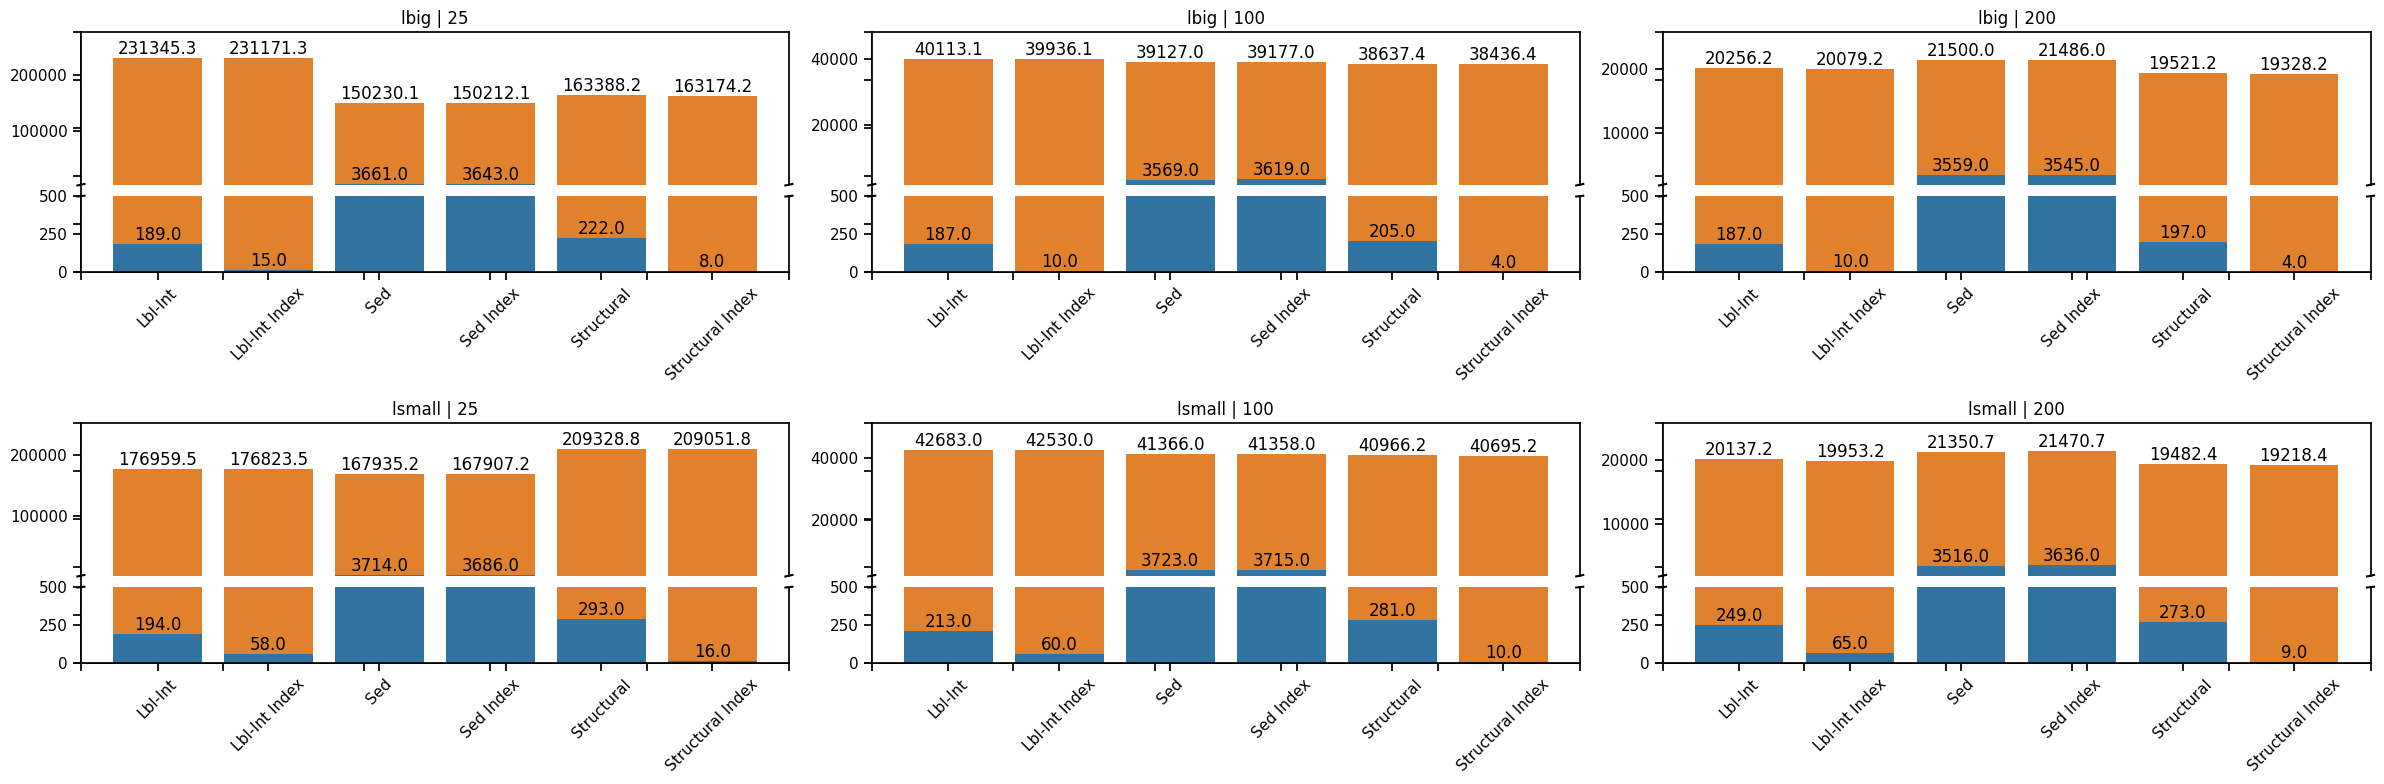

In [150]:
sns.set_context("notebook", font_scale=1)
# Updated function to handle `FacetGrid` subsets
def plot_broken_stacked_bars(data, order, break_bottom=15, break_top=450, height_ratios=[2, 1], *args, **kwargs):
    # print(kwargs)
    # print(kwargs)
    # display(data)
    """Create a broken axis stacked bar plot"""
    # Create figure and gridspec
    ax = plt.gca()
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax.get_subplotspec(), height_ratios=height_ratios, hspace=0.10)

    
    # Create two axes
    ax1 = plt.Subplot(ax.figure, gs[0])
    ax2 = plt.Subplot(ax.figure, gs[1])
    ax.figure.add_subplot(ax1)
    ax.figure.add_subplot(ax2)

    # ax.set_xticks(data["Method"])
    # Plot stacks on both axes
    for ax in [ax1, ax2]:
        # Bottom stack
        sns.barplot(data=data, x='Method', y='searching', 
                   color=hue_color_palette['searching'], ax=ax, order=order)
        
        # Top stack
        sns.barplot(data=data, x='Method', y='verification',
                   bottom=data['searching'],
                   color=hue_color_palette['verification'], ax=ax, order=order)
        # ax.set_xticks([])
        ax.set_xlabel("") #Remove x label
        ax.set_ylabel("") #Remove y label

    for i, total in enumerate(data['total']):
        if total > break_top:
            ax1.text(i, total, f'{total:.1f}', ha='center', va='bottom')

    for i, search_time in enumerate(data['searching']):
        subax = ax2 if search_time < break_bottom else ax1
        # if search_time < break_bottom:
        subax.text(i, search_time, f'{search_time:.1f}', ha='center', va='bottom')
                        
    # Set the limits
    ax1.set_ylim(break_top, data['total'].max() * 1.2)
    ax2.set_ylim(0, break_bottom)
    
    # Hide the appropriate spines
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.set_visible(False)
    
    # Add break marks
    d = .005
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    
    kwargs.update(transform=ax1.transAxes)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
    
    # Add legend to bottom axis only
    ax1.legend().remove()
    ax2.legend().remove()
    ax.tick_params(axis="x", rotation=45)
    # ax2.legend(title='Methods', bbox_to_anchor=(1.05, 1))
    
    # Labels

    #Remove original ax ticks and labels
    # plt.suptitle('Stacked Bar Plot with Broken Y-axis')
    
    # plt.tight_layout()
    # return (ax1, ax2)
    return ax2

order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1)
g = sns.FacetGrid(
    data.plotdata,
    col = 'BaseSize',
    row = 'LabelSize',
    palette = hue_color_palette,
    height=4, aspect=2
    )
# g = (g.map(plot_broken_stacked_bars, break_bottom=15, break_top=150).add_legend())
g.map_dataframe(plot_broken_stacked_bars, break_bottom=500, break_top=2_000, order=order)
g.set_titles('{row_name} | {col_name}')
# for ax in g.axes.flat:
#     ax.set_xticklabels(order, rotation=45, ha="center")  # Rotate labels by 45 degrees

# Add labels manually AFTER mapping
# g.axes.flat[0].set_xlabel() #Set x label on the first axes of the grid
# g.axes.flat[0].set_ylabel() #Set y label on the first axes of the grid

g.set(xticklabels=[])
g.set(yticklabels=[])
# Example dataset
plt.tight_layout()
plt.show()

/tmp/ipykernel_13726/1113304605.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/1113304605.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/1113304605.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/1113304605.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degr

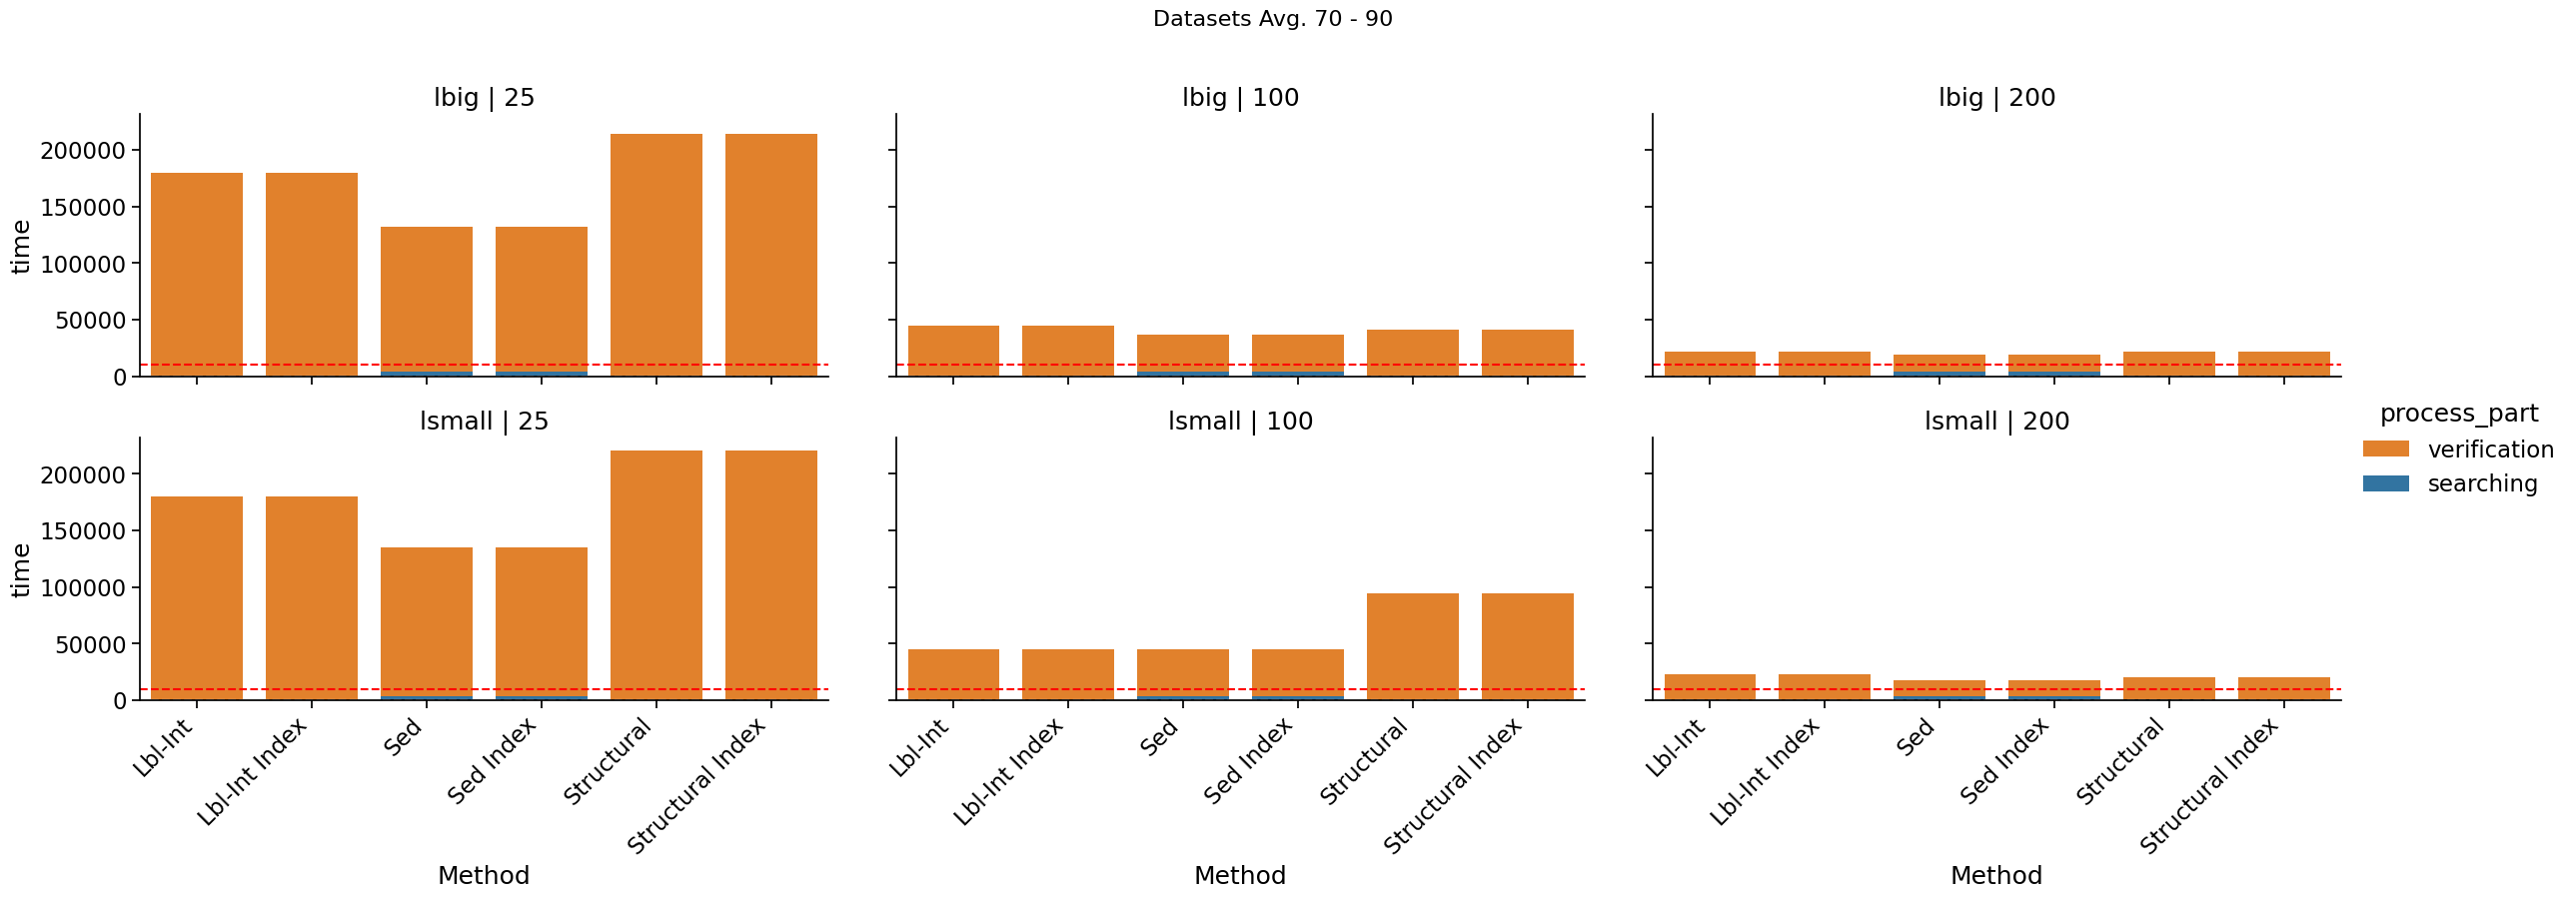

In [92]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

# g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Set the super title
g.fig.suptitle("Datasets Avg. 70 - 90", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
sns.set_context("notebook", font_scale=1)

In [42]:
data10: PlotData = get_plot_data_ds('resources/workloads/generated-10-20')
data30: PlotData = get_plot_data_ds('resources/workloads/generated-30-50')
data70: PlotData = get_plot_data_ds('resources/workloads/generated-70-90')
data1: PlotData = get_plot_data_ds('resources/workloads/generated-1-5')
data150: PlotData = get_plot_data_ds('resources/workloads/generated-150-200')

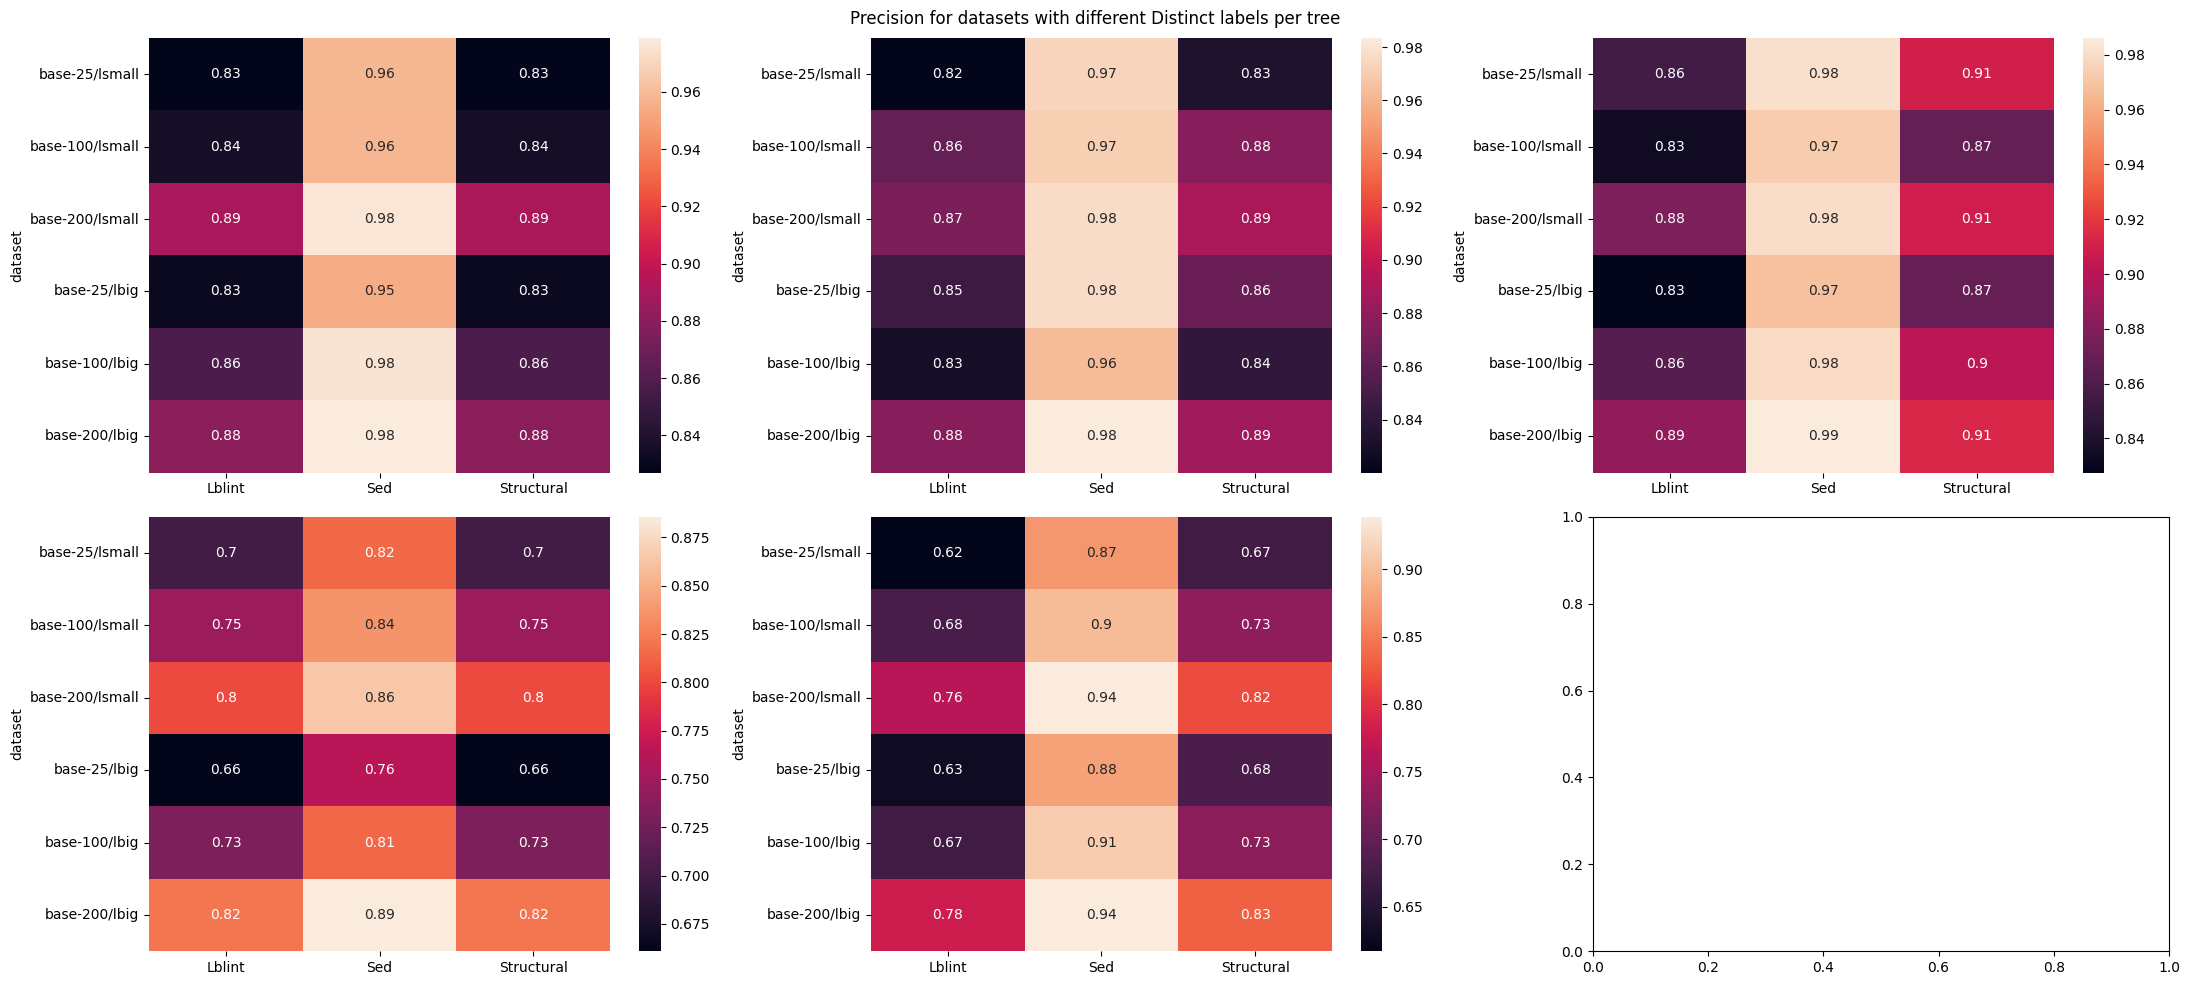

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(22, 10))
hp1 = plot_precision(data10.pdf, axes[0][0])
hp2 = plot_precision(data30.pdf, axes[0][1])
hp3 = plot_precision(data70.pdf, axes[0][2])
hp4 = plot_precision(data1.pdf, axes[1][0])
hp5 = plot_precision(data150.pdf, axes[1][1])

fig.suptitle('Precision for datasets with different Distinct labels per tree')
fig.tight_layout()
# hp1

In [36]:
display(data1.statistics)
display(data150.statistics)

,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,90,119,104.154,1000,0.174,17.429,2962,NaN
0,Base-100/lsmall,90,115,103.353,1000,0.229,17.113,2957,NaN
0,Base-200/lsmall,92,116,102.866,1000,0.247,15.841,2938,NaN
0,Base-25/lbig,90,116,104.000,1000,10.171,18.350,11612,NaN
0,Base-100/lbig,90,122,103.448,1000,9.558,17.714,11187,NaN
0,Base-200/lbig,90,119,103.337,1000,8.546,16.167,10485,NaN


,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,91,116,102.563,1000,0.092,82.622,2976,NaN
0,Base-100/lsmall,91,118,103.407,1000,0.023,82.350,2993,NaN
0,Base-200/lsmall,89,118,102.987,1000,0.002,80.715,3000,NaN
0,Base-25/lbig,92,117,102.797,1000,9.606,83.336,12723,NaN
0,Base-100/lbig,90,116,103.312,1000,8.191,83.361,16182,NaN
0,Base-200/lbig,92,115,103.616,1000,6.456,82.827,20305,NaN


In [83]:
import matplotlib.pyplot as plt
# Function to create a broken axis
def make_broken_axis(ax, ylim_top, ylim_bottom, break_point):
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    ax.set_ylim(ylim_bottom[0], ylim_bottom[1])
    
    ax2 = ax.twinx()
    ax2.spines['bottom'].set_visible(False)
    ax2.set_ylim(ylim_top[0], ylim_top[1])
    
    d = .015  # size of diagonal lines
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    
    # ax2.set_yticks([])
    ax.set_yticks(list(ax.get_yticks()) + list(ax2.get_yticks()))

/tmp/ipykernel_13726/1928924503.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/1928924503.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/1928924503.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_13726/1928924503.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degr

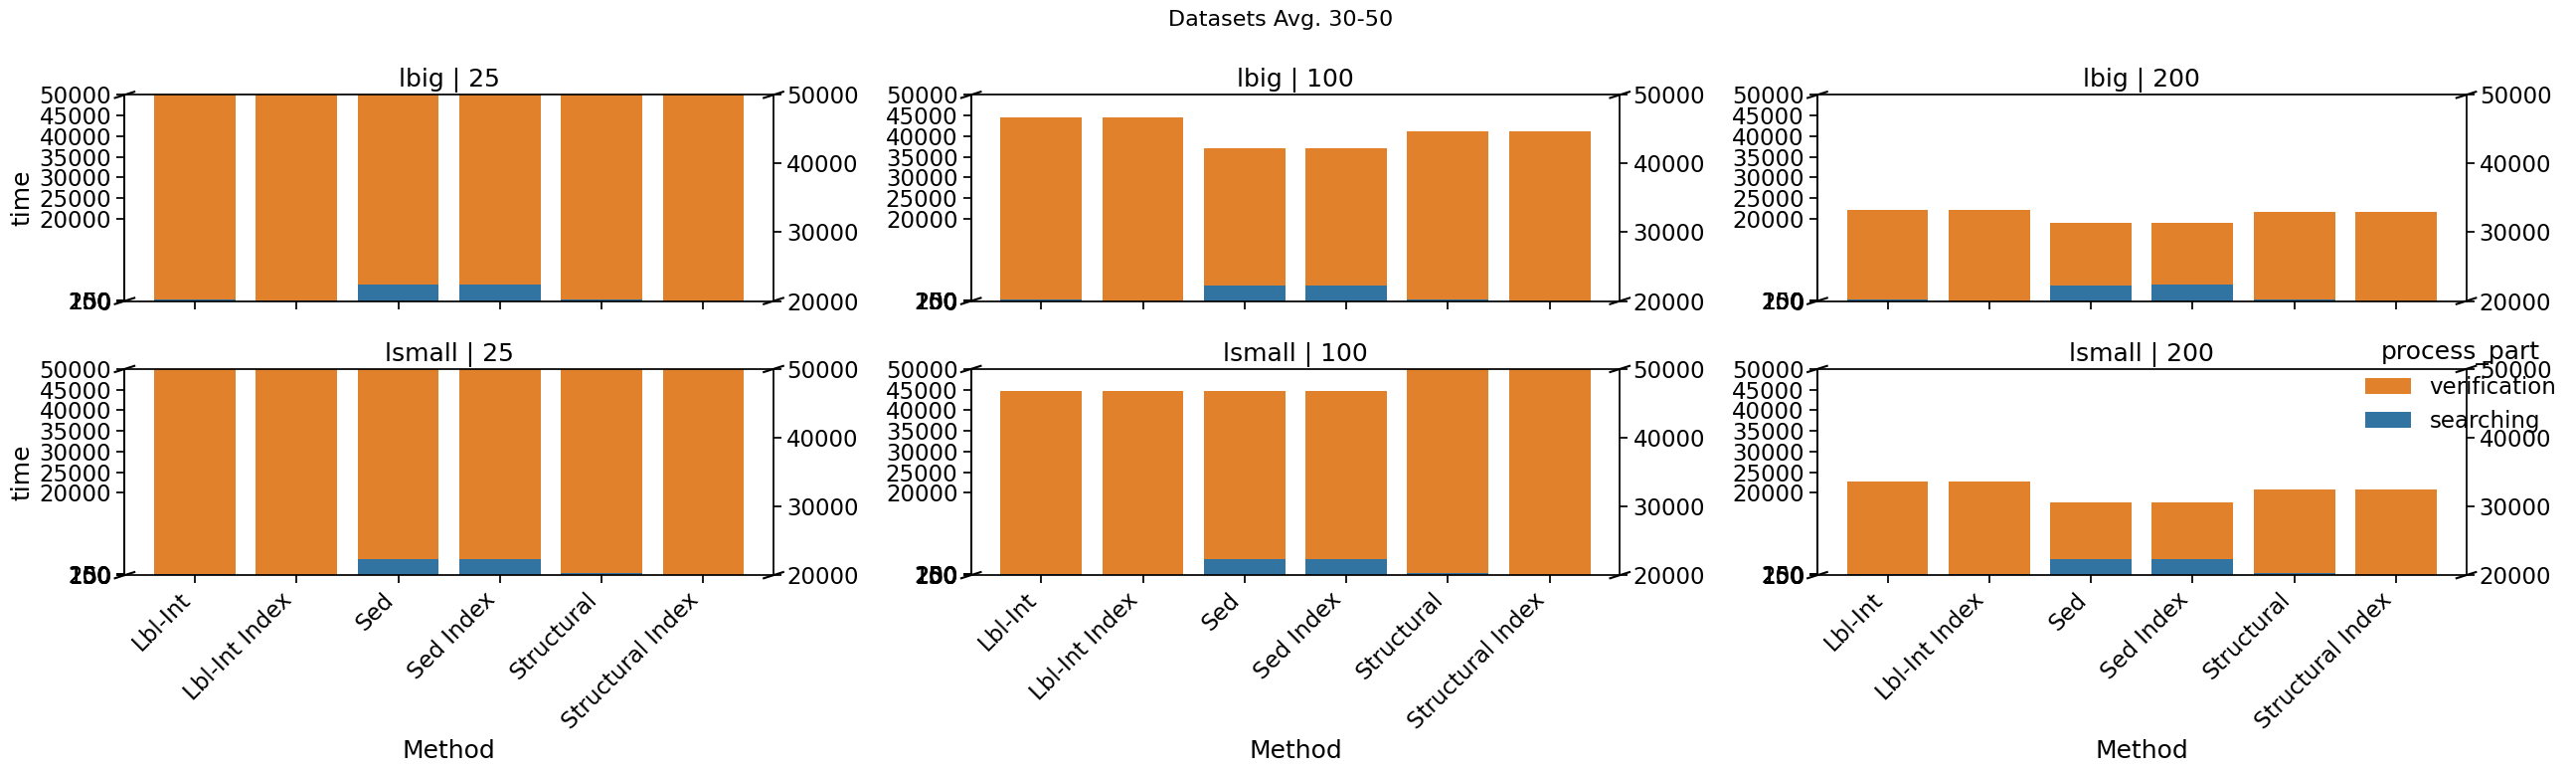

In [85]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    sharey=False,
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

# g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    # ax.axhline(y=10_000, color='r', linestyle='--')
    # ax.axhline(y=10, color='white', linestyle='--')
    make_broken_axis(ax, ylim_top=(20_000, 50_000), ylim_bottom=(10, 250), break_point=50)
    # ax.set_yscale('log', base=math.e)

# Set the super title
g.fig.suptitle("Datasets Avg. 30-50", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in axes:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.tight_layout()
plt.show()
sns.set_context("notebook", font_scale=1)

In [56]:
data.plotdata[data.plotdata['Dataset'] == 'base-100/lbig']

process_part,Dataset,Method,searching,verification,total
0,base-100/lbig,Lbl-Int,187.0,39926.059287,40113.059287
1,base-100/lbig,Lbl-Int Index,10.0,39926.059287,39936.059287
2,base-100/lbig,Sed,3569.0,35557.990246,39126.990246
3,base-100/lbig,Sed Index,3619.0,35557.990246,39176.990246
4,base-100/lbig,Structural,205.0,38432.435468,38637.435468
5,base-100/lbig,Structural Index,4.0,38432.435468,38436.435468


/tmp/ipykernel_22688/2960062890.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


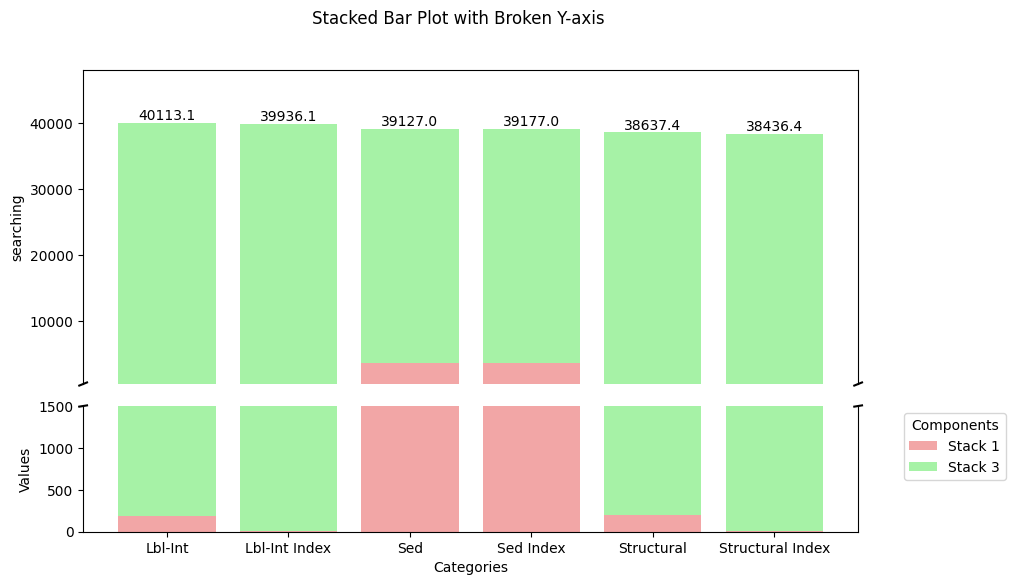

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import gridspec
def plot_broken_stacked_bars(data, break_bottom=15, break_top=450, height_ratios=[2.5, 1]):
    """Create a broken axis stacked bar plot"""
    # Create figure and gridspec
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=height_ratios, hspace=0.10)
    
    # Create two axes
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # Colors for the stacks
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    
    # Plot stacks on both axes
    for ax in [ax1, ax2]:
        # Bottom stack
        sns.barplot(data=data, x='Method', y='searching', 
                   color=colors[0], ax=ax, label='Stack 1')
        
        # Top stack
        sns.barplot(data=data, x='Method', y='verification',
                   bottom=data['searching'],
                   color=colors[2], ax=ax, label='Stack 3')

    for i, total in enumerate(data['total']):
        if total > break_top:
            ax1.text(i, total, f'{total:.1f}',
                   ha='center', va='bottom')
    # Set the limits
    ax1.set_ylim(break_top, data['total'].max() * 1.2)
    ax2.set_ylim(0, break_bottom)
    
    # Hide the appropriate spines
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.set_visible(False)
    
    # Add break marks
    d = .005
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    
    kwargs.update(transform=ax1.transAxes)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
    
    # Add legend to bottom axis only
    ax1.legend().remove()
    ax2.legend(title='Components', bbox_to_anchor=(1.05, 1))
    
    # Labels
    ax2.set_xlabel('Categories')
    ax2.set_ylabel('Values')
    plt.suptitle('Stacked Bar Plot with Broken Y-axis')
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Create the plot
fig, (ax1, ax2) = plot_broken_stacked_bars(data.plotdata[data150.plotdata['Dataset'] == 'base-100/lbig'], break_bottom = 1500)
plt.show()

/tmp/ipykernel_22688/764270701.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


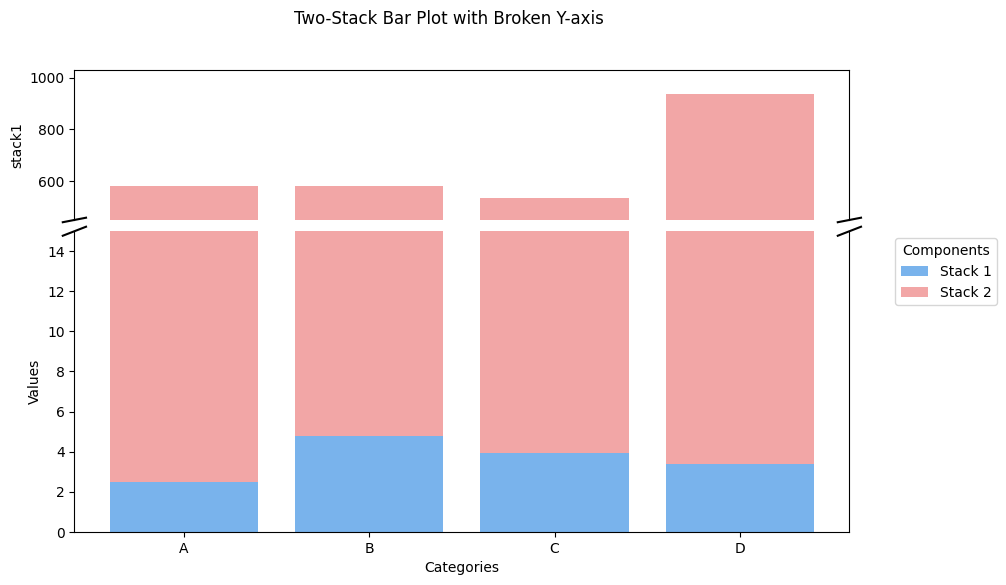

,category,stack1,stack2,cum_stack1,cum_stack2
0,A,2.498160,578.009320,2.498160,580.507481
1,B,4.802857,577.997260,4.802857,582.800117
2,C,3.927976,529.041806,3.927976,532.969782
3,D,3.394634,933.088073,3.394634,936.482707


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import gridspec

# Create sample stacked data
np.random.seed(42)
data = pd.DataFrame({
    'category': ['A', 'B', 'C', 'D'],
    'stack1': np.random.uniform(1, 5, 4),      # Small values
    'stack2': np.random.uniform(500, 1000, 4)  # Large values
})

# Calculate cumulative sum for stacking
data['cum_stack1'] = data['stack1']
data['cum_stack2'] = data['stack1'] + data['stack2']

def plot_broken_stacked_bars(data, break_bottom=15, break_top=450, height_ratios=[1, 2]):
    """Create a broken axis stacked bar plot with 2 stacks"""
    # Create figure and gridspec
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=height_ratios, hspace=0.05)
    
    # Create two axes
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # Colors for the stacks
    colors = ['#66b3ff', '#ff9999']  # Blue and Red
    
    # Plot stacks on both axes
    for ax in [ax1, ax2]:
        # Bottom stack
        sns.barplot(data=data, x='category', y='stack1', 
                   color=colors[0], ax=ax, label='Stack 1')
        
        # Top stack
        sns.barplot(data=data, x='category', y='stack2',
                   bottom=data['cum_stack1'],
                   color=colors[1], ax=ax, label='Stack 2')
    
    # Set the limits
    ax1.set_ylim(break_top, data['cum_stack2'].max() * 1.1)
    ax2.set_ylim(0, break_bottom)
    
    # Hide the appropriate spines
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.set_visible(False)
    
    # Add break marks
    d = .015
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    
    kwargs.update(transform=ax1.transAxes)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
    
    # Add legend to bottom axis only
    ax1.legend().remove()
    ax2.legend(title='Components', bbox_to_anchor=(1.05, 1))
    
    # Labels
    ax2.set_xlabel('Categories')
    ax2.set_ylabel('Values')
    plt.suptitle('Two-Stack Bar Plot with Broken Y-axis')
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Create the plot
fig, (ax1, ax2) = plot_broken_stacked_bars(data)
plt.show()
data